Workflow:
1. Import module and global settings
2. Place for reusable custom functions
3. Reading Boris manual annotation files
4. Reading DLC pose estimation files
5. Calculate normalized footfault
6. Transformation of data structure for statistics and visualization
7. Statistics
8. Visualization

In [2]:
# Import module and global settings

# Import required libraries
import dabest
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import os
import re
from tkinter import filedialog
import tkinter as tk
import seaborn as sns
from statsmodels.stats.multitest import multipletests

os.environ['R_HOME'] = 'C:/Program Files/R/R-4.4.2'

from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.rinterface_lib.callbacks as cb


# Constants
PIXEL_TO_CM = 40 / 480  # Conversion factor from pixels to cm
FRAME_RATE = 30         # Frames per second
VIDEO_LENGTH = 30 * 60     # Video length in seconds
BIN_DURATION = 5 * 60   # Bin duration in seconds (5 minutes)

# Set up the root window
root = tk.Tk()
root.attributes('-topmost', True)  # 將主視窗設置為最上層
root.withdraw()  # 隱藏主視窗

# Suppress decoding errors by ignoring problematic characters
cb.consolewrite_print = lambda x: print(x.decode('utf-8', errors='ignore'))

# 啟用 pandas 和 R 數據框轉換
pandas2ri.activate()

# 安裝 ARTool 和所需的 R 包
artool = importr("ARTool")
car = importr("car")
robjects.r('''
Sys.setlocale("LC_ALL", "en_US.UTF-8")
''')

array(['LC_COLLATE=en_US.UTF-8;LC_CTYPE=en_US.UTF-8;LC_MONETARY=en_US.UTF-8;LC_NUMERIC=C;LC_TIME=en_US.UTF-8'],
      dtype='<U100')

In [40]:
# Place for reusable custom functions

# select_files
def select_files_get_paths(prompt):
    """
    Prompt the user to select multiple files using a GUI.

    Parameters:
    prompt (str): The prompt message to display in the file dialog.

    Returns:
    tuple: A tuple containing the paths of the selected files.
    """
    # create an tuple to store the file paths
    file_paths = []

    while True:

        files = filedialog.askopenfilenames(parent=root, title=prompt)
        
        if not files:
            break
        file_paths.extend(files)

    return file_paths

# Detect the start of valid data in the BORIS file
def detect_valid_data_start(file_path):

    """
    Detect the start of valid data in the BORIS file.

    Parameters:
    file_path (str): The path to the file to read.

    Returns:
    int or None: The line number where valid data starts, or None if not found.
    """
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        for idx, line in enumerate(lines):
            if 'Time' in line and 'Behavior' in line:
                return idx
        print(f"No valid header found in file: {file_path}")
        return None
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None
    
def extract_experiment_info(file_path, file_type):
    """
    Extract experiment condition, trial type, mouse ID, and trial number from the file path.

    Parameters:
    file_path (str): The path to the file.

    Returns:
    tuple: A tuple containing the experiment condition, trial type, mouse ID, and trial number.
    """
    # 使用正則表達式匹配實驗條件、trial type、小鼠 ID 和試驗編號
    if file_type == 'DLC':
        match = re.search(r'/dlc/pose_data/(?P<genotype>[^/]+)/(?P<mouse_id>\d+[A-Z])_', file_path.replace("\\", "/"))
        
        if match:
            genotype = match.group('genotype')
            mouse_id = match.group('mouse_id')
            return genotype, mouse_id
        else:
            print(f"No valid experiment info found in file path: {file_path}")
            return None, None

    if file_type == 'boris':
    # 使用正則表達式匹配 genotype 和 mouse ID
        match = re.search(r'/boris/(?P<genotype>[^/]+)/(?P<mouse_id>\d+[A-Z])\.csv', file_path)
        if match:
            genotype = match.group('genotype')
            mouse_id = match.group('mouse_id')
            return genotype, mouse_id
        else:
            print(f"No valid experiment info found in file path: {file_path}")
            return None, None

def load_deeplabcut_data(file_paths):
    """
    Load and preprocess DeepLabCut data from CSV files.

    Parameters:
    file_paths (tuple): A tuple containing the paths of the selected files.

    Returns:
    dict: A dictionary containing all DeepLabCut data.
    """
    # Create an empty dictionary to store the data
    dlc_data = {}

    for file_path in file_paths:
        try:
            # Load the data from the CSV file
            dlc_full_data = pd.read_csv(file_path, skiprows=2)

            # Extract the genotype and mouse ID from the file path
            genotype, mouse_id = extract_experiment_info(file_path, 'DLC')

            # Initialize the dictionary for the genotype if it doesn't exist
            if (genotype, mouse_id) not in dlc_data:
                dlc_data[(genotype, mouse_id)] = []

            # Add the data to the dictionary
            dlc_data[(genotype, mouse_id)].append(dlc_full_data)

        except Exception as e:
            print(f"Error loading DeepLabCut file {file_path}: {e}")
            return None
    
    return dlc_data
            
def load_boris_data(file_paths):
    """
    Load and preprocess BORIS data from a CSV file.

    Parameters:
    file_path (str): The path to the BORIS CSV file.

    Returns:
    dict: A dictionary where keys are genotype and values are the corresponding BORIS data dataframe.
    """

    # Create an empty dictionary to store the data
    boris_data = {}

    for file_path in file_paths:
        try:
            # Load the data from the CSV file
            boris_full_data = pd.read_csv(file_path, skiprows=detect_valid_data_start(file_path))

            # Extract the genotype and mouse ID from the file path
            genotype, mouse_id = extract_experiment_info(file_path, 'boris')

            # Initialize the dictionary for the genotype if it doesn't exist
            if (genotype, mouse_id) not in boris_data:
                boris_data[(genotype, mouse_id)] = []

            # Add the data to the dictionary
            boris_data[(genotype, mouse_id)].append(boris_full_data)

        except Exception as e:
            print(f"Error loading BORIS file {file_path}: {e}")
            return None
    
    return boris_data
    
def smooth_deeplabcut_data(data, sigma=1):
    """
    Smooth the x and y coordinates of DeepLabCut data using a Gaussian filter.

    Parameters:
    data (DataFrame): The input DeepLabCut data.
    sigma (float): The standard deviation of the Gaussian filter.
    
    Returns:
    DataFrame: The DeepLabCut data with smoothed x and y coordinates.
    """
    data['x_smooth'] = gaussian_filter1d(data['x'], sigma=sigma)
    data['y_smooth'] = gaussian_filter1d(data['y'], sigma=sigma)
    return data

def calculate_displacement(data, pixel_to_cm):
    """
    Calculate the displacement of the animal in cm based on the smoothed x and y coordinates.

    Parameters:
    data (DataFrame): The input DataFrame containing 'x_smooth' and 'y_smooth' columns.
    pixel_to_cm (float): The conversion factor from pixels to cm.
    
    Returns:
    DataFrame: The input DataFrame with additional 'dx', 'dy', and 'displacement' columns.
    """
    data['dx'] = data['x_smooth'].diff().fillna(0)
    data['dy'] = data['y_smooth'].diff().fillna(0)
    data['displacement'] = np.sqrt(data['dx']**2 + data['dy']**2) * pixel_to_cm
    return data

def bin_displacement_data(data, bin_duration, frame_rate):
    """
    Bin displacement data by time intervals and calculate the total displacement in each bin.
    
    Parameters:
    - data (pd.DataFrame): The input DataFrame containing 'frame' and 'displacement' columns.
    - bin_duration (int): The duration of each bin in seconds.
    - frame_rate (int): The frame rate of the video in frames per second.

    Returns:
    - pd.DataFrame: The binned displacement data with 'TimeBin' and 'total_displacement' columns.
    """
    data['time'] = data['frame'] / frame_rate
    data['TimeBin'] = (data['time'] // bin_duration).astype(int)
    displacement_binned = data.groupby('TimeBin')['displacement'].sum().reset_index()
    displacement_binned.columns = ['TimeBin', 'total_displacement']
    return displacement_binned

def fill_missing_time_bins(data, total_bins):
    """
    Fills missing time bins in the given DataFrame with zeros for all behavior columns.
    
    Parameters:
    - data (pd.DataFrame): The input DataFrame containing `TimeBin` and behavior columns.
    - total_bins (int): The total number of bins expected (e.g., maximum TimeBin + 1).
    
    Returns:
    - pd.DataFrame: The DataFrame with missing time bins filled with zeros.
    """
    # 確保 TimeBin 是索引，並重設完整索引
    all_bins = pd.DataFrame({'TimeBin': range(total_bins)})  # 建立完整的 TimeBin 範圍
    data = pd.merge(all_bins, data, on="TimeBin", how="left")  # 將數據與完整範圍合併
    data.fillna(0, inplace=True)  # 將缺失值填充為 0
    
    return data

def bin_behavior_data(data, bin_duration):
    """
    Bin behavior data by time intervals and calculate the counts of each behavior in each bin.

    Parameters:
    - data (pd.DataFrame): The input DataFrame containing 'time' and 'behavior' columns.
    - bin_duration (int): The duration of each bin in seconds.

    Returns:
    - pd.DataFrame: The binned behavior data with 'TimeBin' and behavior columns.
    """

    data['TimeBin'] = (data['Time'] // bin_duration).astype(int)
    data_filled = fill_missing_time_bins(data, VIDEO_LENGTH // BIN_DURATION)
    behavior_binned = data_filled.groupby(['TimeBin', 'Behavior']).size().unstack(fill_value=0).reset_index()
    return behavior_binned

def normalize_behavior_by_displacement(behavior_binned_list, displacement_binned_list):
    """
    Normalize behavior data by total displacement in each time bin for a single genotype.

    Parameters:
    - behavior_binned_list (list): A list of DataFrames with binned behavior data.
                                   Each DataFrame should have time bins as indices and behavior counts as columns.
    - displacement_binned_list (list): A list of DataFrames with binned displacement data.
                                       Each DataFrame should have time bins as indices and a single column for displacement.

    Returns:
    - list: A list of normalized DataFrames, with the same structure as the input `behavior_binned_list`.
    """
    if len(behavior_binned_list) != len(displacement_binned_list):
        raise ValueError("The number of behavior and displacement DataFrames must match.")
    
    normalized_behavior_list = []

    for behavior_df, displacement_df in zip(behavior_binned_list, displacement_binned_list):
        # Ensure indices align
        if not behavior_df.index.equals(displacement_df.index):
            raise ValueError("Time bins do not match between behavior and displacement data.")
        
        # Drop `TimeBin` column if it exists
        behavior_data = behavior_df.drop(columns=["TimeBin"], errors="ignore")

        # Normalize each behavior count by the corresponding displacement
        normalized_df = behavior_data.div(displacement_df.iloc[:, 1], axis=0)

        # Transform unit from /pixel to /m
        normalized_df = normalized_df * 100
        
        # Append the normalized DataFrame to the list
        normalized_behavior_list.append(normalized_df)

        # Add a forelimb column to the DataFrame
        normalized_df["forelimb"] = normalized_df["L_fl"] + normalized_df["R_fl"]

        # Add a hindlimb column to the DataFrame
        normalized_df["hindlimb"] = normalized_df["L_hl"] + normalized_df["R_hl"]

        # Add a total column to the DataFrame
        normalized_df["total"] = normalized_df["forelimb"] + normalized_df["hindlimb"]



    return normalized_behavior_list

def convert_to_dabest_format(normalized_binned_data):
    """
    Convert normalized binned data to a format accepted by dabest, including a TimeBin column and mouse group as Bin.

    Parameters:
    - normalized_binned_data (dict): Dictionary containing normalized binned data. Keys are genotypes and values are lists of DataFrames.

    Returns:
    - DataFrame: A long-format DataFrame suitable for dabest, including a TimeBin column and mouse group as Bin.
    """
    # List to store all melted DataFrames
    melted_dfs = []

    # Iterate over each genotype and its associated DataFrames
    for group, dataframes in normalized_binned_data.items():

        (genotype, mouse_id) = group

        for df in dataframes:
            # Ensure the input is a DataFrame
            if not isinstance(df, pd.DataFrame):
                raise TypeError(f"Expected a DataFrame but got {type(df)} for group {group}.")
            
            # Add a TimeBin column to the DataFrame
            df = df.copy()
            df["TimeBin"] = range(1, len(df) + 1)

            # Melt the DataFrame to long format
            melted_df = pd.melt(
                df,
                id_vars=["TimeBin"],
                var_name="Behavior",
                value_name="Value"
            )
            
            # Add the key as a new column (Group)
            melted_df["Genotype"] = genotype
            melted_df["Mouse"] = mouse_id
            
            # Append the melted DataFrame to the list
            melted_dfs.append(melted_df)

    # Combine all melted DataFrames into a single DataFrame
    long_format_data = pd.concat(melted_dfs, ignore_index=True)

    long_format_data["Groups"] = long_format_data["Genotype"].astype(str) + "_" + long_format_data["Behavior"].astype(str)
    return long_format_data

def convert_to_ARTool_format(normalized_binned_data):
    """
    Convert normalized binned data to a format accepted by ARTool.

    Parameters:
    - normalized_binned_data (dict): Dictionary containing normalized binned data. Keys are genotypes and values are lists of DataFrames.

    Returns:
    - artool_df(DataFrame): A long-format DataFrame suitable for ARTool.
    """



    # 初始化一個空列表來存儲轉換後的數據
    artool_data = []

    # 遍歷 normalized_binned_data 中的每個組別
    for group, dfs in normalized_binned_data.items():
        (genotype, mouse_id) = group

        for i, df in enumerate(dfs):
            # 將每個 DataFrame 轉換為長格式
            df_long = df.reset_index().melt(
                id_vars=['index'],  # 假設 'index' 是時間 bin
                value_vars=['L_fl', 'L_hl', 'R_fl', 'R_hl', 'forelimb', 'hindlimb', 'total'],  # 需要轉換的列
                var_name='Behavior',  # 行為類型
                value_name='Value'   # 測量值
            )
            
            # 添加 Subject 和 Condition 信息
            df_long['Subject'] = mouse_id  # 假設第 i 個 DataFrame 對應第 i 隻個體
            df_long['Genotype'] = genotype  # 添加組別 (ctl 或 exp)
            df_long['Mouse'] = mouse_id
            
            # 將轉換後的數據添加到列表
            artool_data.append(df_long)

    # 合併所有數據到一個 DataFrame
    artool_df = pd.concat(artool_data, ignore_index=True)

    # 重命名欄位，符合 ARTool 的需求
    artool_df.rename(columns={'index': 'TimeBin'}, inplace=True)

    return artool_df

def artool_analysis(artool_data, BehaviorEvent, time_bins):
    """
    Perform ARTool analysis with weighted data using sample replication to handle imbalanced group sizes.

    Parameters:
    - artool_data (DataFrame): Input data containing 'Behavior', 'TimeBin', 'Value', 'Genotype', and 'Subject'.
    - BehaviorEvent (str): The behavior event to analyze.
    - time_bins (list): A list of selected time bins to include in the analysis.

    Returns:
    - ANOVA result: The ANOVA table from ARTool analysis.
    """
    try:
        # 篩選數據
        artool_data_filtered = artool_data[
            (artool_data['Behavior'] == BehaviorEvent) & 
            (artool_data['TimeBin'].isin(time_bins))
        ]

        if artool_data_filtered.empty:
            print(f"Filtered data is empty for behavior: {BehaviorEvent}, time_bins: {time_bins}")
            return None

        # 計算權重
        group_counts = artool_data_filtered.groupby('Genotype').size()
        total_count = len(artool_data_filtered)
        weights = artool_data_filtered['Genotype'].map(lambda g: total_count / group_counts[g])

        # 複製數據以模擬加權
        weighted_data = artool_data_filtered.loc[artool_data_filtered.index.repeat(weights.astype(int))]

        # 確保 Genotype、TimeBin 和 Subject 是因子
        r_data = pandas2ri.py2rpy(weighted_data)
        robjects.r.assign("r_data", r_data)
        robjects.r('''
        library(dplyr)
        r_data <- r_data %>%
          mutate(Genotype = as.factor(Genotype),
                 TimeBin = as.factor(TimeBin),
                 Subject = as.factor(Subject))
        ''')

        # 定義公式
        formula = Formula("Value ~ TimeBin * Genotype + (1 | Genotype:Subject)")

        # 使用 ARTool 進行分析
        artool = importr("ARTool")
        art_model = artool.art(formula, data=robjects.r['r_data'])

        # ANOVA 分析
        anova_result = robjects.r['anova'](art_model)

        return anova_result

    except Exception as e:
        print(f"Error during ARTool analysis: {e}")
        return None
    
def plot_foot_fault_line_chart(artool_data, BehaviorEvent, time_bins):
    """
    Plot a line chart showing foot fault counts over time bins for different genotypes.

    Parameters:
    - artool_data (DataFrame): The input data containing 'Behavior', 'TimeBin', 'Value', and 'Genotype'.
    - BehaviorEvent (str): The behavior event to plot.
    - time_bins (list): The selected time bins to include in the plot.

    Returns:
    - None: Displays the line chart.
    """
    # 篩選數據
    artool_data_filtered = artool_data[artool_data['Behavior'] == BehaviorEvent]
    artool_data_filtered = artool_data_filtered[artool_data_filtered['TimeBin'].isin(time_bins)]
    artool_data_filtered = artool_data_filtered.applymap(
        lambda x: x.encode('utf-8', 'ignore').decode('utf-8') if isinstance(x, str) else x
    )
    data = artool_data_filtered

    # 計算平均值和標準誤
    summary = data.groupby(['TimeBin', 'Genotype']).agg(
        mean_value=('Value', 'mean'),
        sem_value=('Value', lambda x: np.std(x) / np.sqrt(len(x)))
    ).reset_index()

    # 計算標題中的時間範圍
    start_min = (min(time_bins) - 1) * 5 + 5  # 起始分鐘數
    end_min = max(time_bins) * 5  + 5            # 結束分鐘數

    # 繪製摺線圖
    plt.figure(figsize=(10, 6))
    palette = ["#5874A2", "#C5905C"]

    # gird background
    sns.set_style("whitegrid")

    # 使用Seaborn繪製線條
    sns.lineplot(
        data=summary, 
        x='TimeBin', 
        y='mean_value', 
        hue='Genotype', 
        marker='o', 
        palette=palette,
        linewidth=3,
        markersize=9,
        err_style=None
    )

    # 設置X軸刻度標籤
    plt.xticks(ticks=range(min(time_bins), max(time_bins) + 1), labels=[f"{i * 5 + 2.5}" for i in time_bins])

    # 添加誤差條
    for genotype in summary['Genotype'].unique():
        subset = summary[summary['Genotype'] == genotype]
        plt.errorbar(
            subset['TimeBin'], 
            subset['mean_value'], 
            yerr=subset['sem_value'], 
            fmt='none', 
            capsize=5, 
            capthick=2, 
            linewidth=2.5,
            ecolor=palette[summary['Genotype'].unique().tolist().index(genotype)]
        )

    # 設置標題、軸標籤和圖例
    plt.title(f'Grid Walking {BehaviorEvent} {start_min}-{end_min}min', fontsize=30)
    plt.xlabel('Time (min)', fontsize=24)
    plt.ylabel('Normalized Foot Faults (/m)', fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.tight_layout()

def correct_and_save_pvalues(mean_diff, output_file):
    """
    Perform Bonferroni and FDR-BH corrections on p-values from statistical tests
    and save the results to a text file.

    Parameters:
    - mean_diff (pd.DataFrame): A DataFrame containing statistical test results, 
      including p-values to be corrected.
      Required columns: 'pvalue_permutation', 'pvalue_welch', 'pvalue_mann_whitney'.
    - output_file (str): Path to the output text file where corrected results will be saved.

    Returns:
    - pd.DataFrame: The original DataFrame with additional columns for corrected p-values.
    """

    mean_diff = mean_diff.copy()  # 明確地創建一個副本
    
    # Ensure the required columns exist
    required_columns = ['pvalue_permutation', 'pvalue_welch', 'pvalue_mann_whitney']
    for col in required_columns:
        if col not in mean_diff.columns:
            raise ValueError(f"Column '{col}' is missing from the DataFrame.")
    
    # Check for null values
    if mean_diff[required_columns].isnull().any().any():
        raise ValueError("The DataFrame contains null values in p-value columns.")

    # Initialize dictionaries to store corrected p-values
    corrected_p_values = {"bonferroni": {}, "fdr_bh": {}}
    
    # Perform corrections for each type of p-value
    for key in required_columns:
        values = mean_diff[key].values
        # Bonferroni correction
        _, bonferroni_corrected, _, _ = multipletests(values, alpha=0.05, method="bonferroni")
        corrected_p_values["bonferroni"][key] = bonferroni_corrected

        # FDR-BH correction
        _, fdr_corrected, _, _ = multipletests(values, alpha=0.05, method="fdr_bh")
        corrected_p_values["fdr_bh"][key] = fdr_corrected

    # Add corrected p-values to the DataFrame
    for key in required_columns:
        mean_diff.loc[:, f"bonf_{key}"] = corrected_p_values["bonferroni"][key]
        mean_diff.loc[:, f"fdr_{key}"] = corrected_p_values["fdr_bh"][key]


    # Save results to the output file
    with open(output_file, "w") as f:
        f.write("Corrected P-Values Results:\n")
        f.write("=" * 50 + "\n")
        for index, row in mean_diff.iterrows():
            f.write(f"Row {index + 1}:\n")
            f.write(f"Original P-Values:\n")
            f.write(f"  Permutation: {row['pvalue_permutation']}\n")
            f.write(f"  Welch: {row['pvalue_welch']}\n")
            f.write(f"  Mann-Whitney: {row['pvalue_mann_whitney']}\n")
            f.write("\nBonferroni Corrected P-Values:\n")
            f.write(f"  Permutation: {row[f'bonf_pvalue_permutation']}\n")
            f.write(f"  Welch: {row[f'bonf_pvalue_welch']}\n")
            f.write(f"  Mann-Whitney: {row[f'bonf_pvalue_mann_whitney']}\n")
            f.write("\nFDR-BH Corrected P-Values:\n")
            f.write(f"  Permutation: {row[f'fdr_pvalue_permutation']}\n")
            f.write(f"  Welch: {row[f'fdr_pvalue_welch']}\n")
            f.write(f"  Mann-Whitney: {row[f'fdr_pvalue_mann_whitney']}\n")
            f.write(f"\nMean Difference: {row['difference']}\n")
            f.write("=" * 50 + "\n")

    print(f"Corrected p-values saved to {output_file}.")
    return mean_diff



In [6]:
# Reading Boris manual annotation files

# Load BORIS data
boris_file = select_files_get_paths("Select BORIS file")
boris_data = load_boris_data(boris_file)

In [7]:
# Reading DLC pose estimation files

# Load DeepLabCut data
dlc_files = select_files_get_paths("Select DeepLabCut files")
dlc_data = load_deeplabcut_data(dlc_files)

In [8]:
#  smoothing DLC data and calculating displacement
smoothed_dlc_data = {}
displacement_dlc_data = {}

for genotype, data_list in dlc_data.items():
    smoothed_dlc_data[genotype] = [smooth_deeplabcut_data(data, sigma=1) for data in data_list]
    for data in smoothed_dlc_data[genotype]:
        if 'frame' not in data.columns:
            data['frame'] = data.index
    displacement_dlc_data[genotype] = [calculate_displacement(data, pixel_to_cm=PIXEL_TO_CM) for data in smoothed_dlc_data[genotype]]

# Binning DLC data
binned_dlc_data = {}
for genotype, data_list in displacement_dlc_data.items():
    binned_dlc_data[genotype] = [bin_displacement_data(data, bin_duration=BIN_DURATION, frame_rate=FRAME_RATE) for data in data_list]

In [9]:
# Binning BORIS data
binned_boris_data = {}

for groups, data_list in boris_data.items():
    binned_boris_data[groups] = [bin_behavior_data(data, bin_duration=BIN_DURATION) for data in data_list]

In [10]:
# Calculate normalized footfault

normalized_binned_data = {}

for groups in binned_boris_data.keys():
    (genotype, mouse_id) = groups

    # binned_boris_data[genotype] 和 binned_dlc_data[genotype] 是 list
    normalized_binned_data[(genotype, mouse_id)] = normalize_behavior_by_displacement(
        binned_boris_data[(genotype, mouse_id)], binned_dlc_data[(genotype, mouse_id)]
    )


In [11]:
# Convert to ARTool format

artool_data = convert_to_ARTool_format(normalized_binned_data)

In [41]:
# ARTool analysis

time_bin_selections = [[1, 2, 3, 4, 5]]
behavior_selections = ['forelimb', 'hindlimb', 'total']

# ART 分析
for behavior in behavior_selections:
    for time_bins in time_bin_selections:
        anova_result = artool_analysis(artool_data, behavior, time_bins)

        # save the result to a file
        start_min = (min(time_bins) - 1) * 5 + 5  # 起始分鐘數
        end_min = max(time_bins) * 5  + 5            # 結束分鐘數
        with open(f"ART_{behavior}_{start_min}-{end_min}.txt", "w") as f:
            f.write(str(anova_result))


d:\miniforge3\envs\basic\lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
d:\miniforge3\envs\basic\lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
d:\miniforge3\envs\basic\lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [15]:
# plot line chart

for behavior in behavior_selections:
    for time_bins in time_bin_selections:
        plot_foot_fault_line_chart(artool_data, behavior, time_bins)

        # save the plot to a file
        start_min = (min(time_bins) - 1) * 5 + 5
        end_min = max(time_bins) * 5 + 5
        plt.savefig(f"ART_{behavior}_{start_min}-{end_min}.png")
        plt.close()
        



In [12]:
# Transformation of data structure for statistics and visualization
data4dabest = {}

data4dabest = convert_to_dabest_format(normalized_binned_data)

Corrected p-values saved to corrected_pvalues_forelimb.txt.
Corrected p-values saved to corrected_pvalues_hindlimb.txt.
Corrected p-values saved to corrected_pvalues_total.txt.
Corrected p-values saved to the following files:
- corrected_pvalues_forelimb.txt
- corrected_pvalues_hindlimb.txt
- corrected_pvalues_total.txt


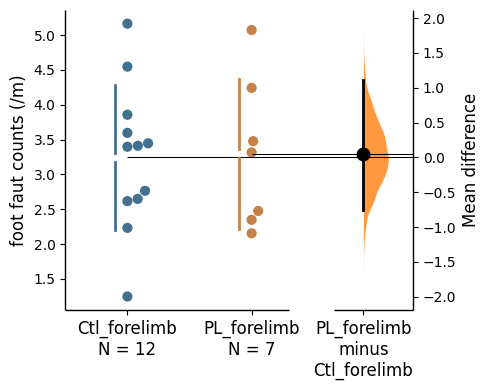

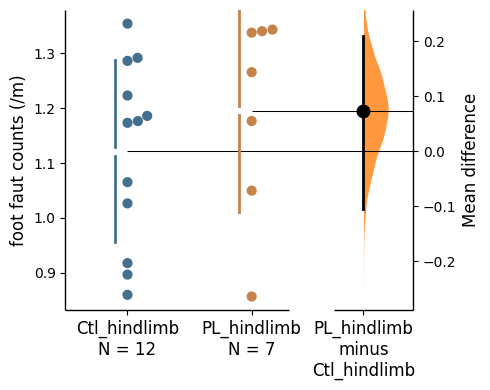

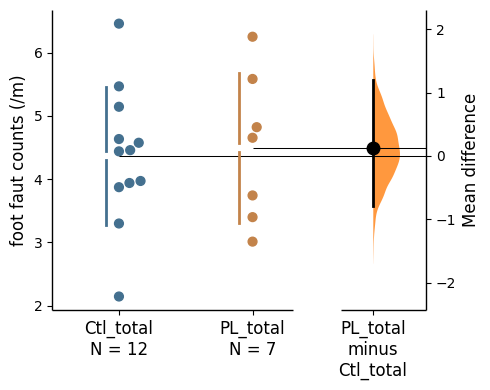

In [17]:
# post-hoc analysis with p-value correction
time_bin_selections = [[1]]
behavior_selections = ['forelimb', 'hindlimb', 'total']

# 初始化結果儲存
all_results = []  # 用來存儲所有的 mean_diff 結果以進行校正
output_files = []  # 用來保存每次的輸出文件路徑

# 逐一處理每個行為和時間範圍
for behavior in behavior_selections:
    mean_diff_list = []  # 存儲當前行為的所有 mean_diff 結果
    for TimeBin in time_bin_selections:
        # 過濾數據
        filtered_data = data4dabest[
            (data4dabest['Groups'].isin([f"Ctl_{behavior}", f"PL_{behavior}"])) &
            (data4dabest['TimeBin'].isin(TimeBin))
        ]

        if filtered_data.empty:
            print(f"No data for {behavior} in time bin {TimeBin}, skipping...")
            continue

        # 按 Mouse 分組求和
        summed_data = filtered_data.groupby(['Groups', 'Mouse']).sum(numeric_only=True).reset_index()

        # 加載 dabest 資料
        dabest_data = dabest.load(
            data=summed_data,
            x='Groups',
            y='Value',
            idx=(f"Ctl_{behavior}", f"PL_{behavior}")
        )

        # 執行統計測試
        mean_diff = dabest_data.mean_diff.statistical_tests.copy()  # 增加 .copy()，避免警告
        mean_diff.loc[:, "TimeBin"] = TimeBin[0]  # 使用 .loc 明確指定列進行修改

        # 將結果添加到 mean_diff_list
        mean_diff_list.append(mean_diff)

        # plot and save
        dabest_data.mean_diff.plot(swarm_label=f"foot faut counts (/m)", raw_marker_size=10)
        plt.savefig(f"mean_diff_{behavior}_pool_all.png")


    # 檢查是否有 mean_diff 結果
    if not mean_diff_list:
        print(f"No valid results for behavior {behavior}, skipping...")
        continue

    # 合併所有時間範圍的 mean_diff 結果
    mean_diff_combined = pd.concat(mean_diff_list, ignore_index=True)

    # 校正 p-values 並保存結果
    output_file = f"corrected_pvalues_{behavior}.txt"
    corrected_df = correct_and_save_pvalues(mean_diff_combined, output_file)

    # 存儲校正後的結果
    all_results.append(corrected_df)
    output_files.append(output_file)

# 結果總結
print("Corrected p-values saved to the following files:")
for output_file in output_files:
    print(f"- {output_file}")


In [ ]:
# dabest Statistics Batch Processing

time_bin_selections = [[1, 2, 3, 4, 5, 6], [2, 3, 4, 5, 6], [2, 3, 4, 5], [2, 3, 4], [2, 3], [1], [2], [3], [4], [5], [6]]
behavior_selections = ['forelimb', 'hindlimb', 'total']

# 批量處理每個行為和時間範圍
for behavior in behavior_selections:
    for time_bins in time_bin_selections:
        # 過濾數據根據行為和時間範圍
        filtered_data = data4dabest[
            (data4dabest['Groups'].isin([f"Ctl_{behavior}", f"PL_{behavior}"])) &
            (data4dabest['TimeBin'].isin(time_bins))
        ]

        summed_data = filtered_data.groupby(['Groups', 'Mouse']).sum(numeric_only=True).reset_index()

        # 加載 dabest 資料
        dabest_data = dabest.load(
            data=summed_data, 
            x='Groups', 
            y='Value', 
            idx=(f"Ctl_{behavior}", f"PL_{behavior}")
        )
        
        # 執行統計測試
        mean_diff = dabest_data.mean_diff.statistical_tests
        

        # 保存統計結果到文件
        start_min = (min(time_bins) - 1) * 5  # 起始分鐘數
        end_min = max(time_bins) * 5          # 結束分鐘數
        with open(f"dabest_{behavior}_{start_min}-{end_min}_stats.txt", "w") as f:
            f.write(str(mean_diff))
        
        # 繪製群組間的平均差異圖
        plot = dabest_data.mean_diff.plot(
            float_contrast=False, 
            dpi=600,
            swarm_label="FootFault Counts", 
            title=f"Grind Walking {behavior} {start_min}-{end_min}min"
        )


        # 保存圖形到文件
        plt.savefig(
            f"dabest_{behavior}_{start_min}-{end_min}_plot.png",
            bbox_inches="tight",  # 自動調整圖形邊界以適應內容
            pad_inches=0.2,  # 圖形內容和邊界的緩衝區大小
            dpi=600  # 高解析度
        )
        plt.close()



Travel Distance----------------------------------

In [16]:
dlcdata4ART = convert_to_dabest_format(binned_dlc_data)

In [22]:
# ARTool analysis

time_bin_selections = [[0, 1, 2, 3, 4, 5]]
behavior_selections = ['total_displacement']

# ART 分析
for behavior in behavior_selections:
    for time_bins in time_bin_selections:
        anova_result = artool_analysis(dlcdata4ART, behavior, time_bins)

        # save the result to a file
        start_min = (min(time_bins) - 1) * 5 + 5  # 起始分鐘數
        end_min = max(time_bins) * 5  + 5            # 結束分鐘數
        with open(f"ART_{behavior}_{start_min}-{end_min}.txt", "w") as f:
            f.write(str(anova_result))


In [26]:
# plot line chart

for behavior in behavior_selections:
    for time_bins in time_bin_selections:
        plot_foot_fault_line_chart(dlcdata4ART, behavior, time_bins)

        # save the plot to a file
        start_min = (min(time_bins) - 1) * 5 + 5
        end_min = max(time_bins) * 5 + 5

        plt.title(f'Grid Walking {start_min}-{end_min}min', fontsize=30)
        plt.xlabel('Time (min)', fontsize=24)
        plt.ylabel('Travel Distance (cm)', fontsize=24)

        plt.savefig(f"ART_{behavior}_{start_min}-{end_min}.png")
        plt.close()

Old data (low dose)-----------------------------------------------------------------

In [17]:
# 原始數據 # all limbs
ctl_data = [8.647798742, 12.5, 5.287356, 4.761905, 10.31866, 5.647059, 8.630952, 9.261745]
exp_data = [4.410143, 4.66596, 4.463209, 10.45752, 5.480869, 9.254499, 6.432749, 11.45631, 
            6.542056, 6.290116, 8.851675, 7.175399, 7.433809, 10.10009, 8.450704]

In [19]:
# 原始數據 #  forelimbs
ctl_data = [5.660377, 9.166667, 3.448276, 3.088803, 6.525038, 4.235294, 4.464286, 6.174497]
exp_data = [3.307607, 2.226935, 2.171291, 5.555556, 3.516029, 6.169666, 3.508772, 6.990291, 3.38785, 4.36457, 5.861244, 4.783599, 4.276986, 5.732484, 4.767064]

In [21]:
# 原始數據 # hindlimbs
ctl_data = [2.987421, 3.333333, 1.83908, 1.673102, 3.793627, 1.411765, 4.166667, 3.087248]
exp_data = [1.102536, 2.439024, 2.291918, 4.901961, 1.96484, 3.084833, 2.923977, 4.466019, 3.154206, 1.925546, 2.990431, 2.3918, 3.156823, 4.367607, 3.68364]

DABEST v2024.03.29
                  
Good afternoon!
The current time is Mon Jan  6 14:27:37 2025.

The unpaired mean difference between ctl and exp is 0.203 [95%CI -0.601, 1.05].
The p-value of the two-sided permutation t-test is 0.655, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`
  control test  control_N  test_N      effect_size is_paired  difference  ci  \
0     ctl  exp          8      15  mean difference      None    0.203147  95   

   bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0 -0.60148  1.051555               0.655      0.659471         -0.44979   

   pvalue

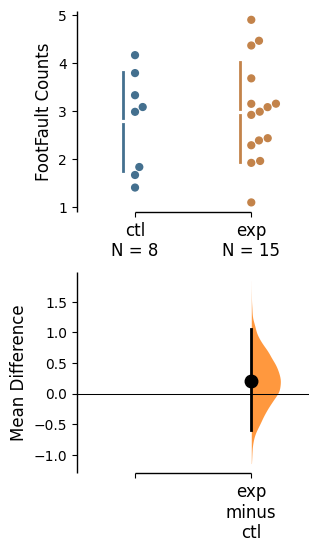

In [22]:
#statistical analysis and plot

import pandas as pd
import dabest

# 資料整理：長格式
data = {
    'Groups': ['ctl'] * len(ctl_data) + ['exp'] * len(exp_data),
    'Value': ctl_data + exp_data
}
df = pd.DataFrame(data)

# 使用 dabest 進行分析
dabest_data = dabest.load(
    data=df,
    idx=("ctl", "exp"),  # 明確指定組別順序
    x="Groups",
    y="Value"
)

# 獲取統計測試結果
mean_diff = dabest_data.mean_diff
mean_diff_stats = mean_diff.statistical_tests
print(mean_diff)  # 顯示統計結果
print(mean_diff_stats)  # 顯示統計測試結果





# 繪製圖表
plot = mean_diff.plot(
    swarm_label="FootFault Counts",
    contrast_label="Mean Difference",
    float_contrast=False
)
